In [1]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=True)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [3]:
def image_encode(image_values: np.array, npixels: int):
    '''
    Args:
        image_values: 2-dimensional array (non hairy) of image data
    '''
    norm: float = np.linalg.norm(image_values)
    normalized_image_values: np.array = image_values.flatten()/norm
    return normalized_image_values
    

In [4]:
pixelValues = []
for i in range(4):
    value = 0.33 * i
    pixelValues.append(value)
    print(value)


0.0
0.33
0.66
0.99


[[0.   0.33]
 [0.66 0.99]]


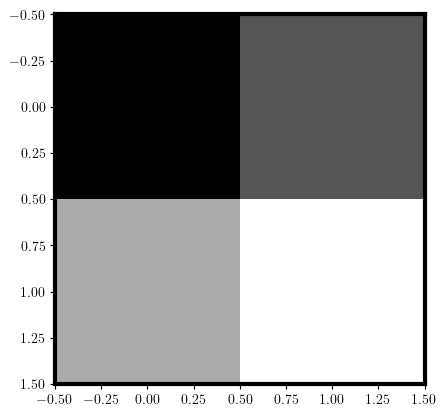

[0.         0.26726124 0.53452248 0.80178373]


In [5]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
print(normalized)

In [6]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = np.random.randn(n_train,n)+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

In [8]:
a = generate_training(normalized, 100, 2)
print(a)
for i in a:
    print(np.linalg.norm(i))

(100, 4)
(4,)
[[ 0.57783984+0.j  0.30807145+0.j  0.57899018+0.j  0.48576072+0.j]
 [-0.77941512+0.j  0.59356852+0.j -0.07397829+0.j  0.1863215 +0.j]
 [-0.41666856+0.j -0.11343743+0.j -0.29341698+0.j  0.85289257+0.j]
 [ 0.12438246+0.j -0.15386701+0.j -0.43745441+0.j  0.87720441+0.j]
 [-0.68917202+0.j  0.64908543+0.j  0.25434139+0.j  0.19758665+0.j]
 [-0.38452304+0.j  0.45745944+0.j -0.57573788+0.j  0.55803116+0.j]
 [ 0.6995513 +0.j  0.07191031+0.j -0.40464609+0.j  0.58456687+0.j]
 [ 0.04138612+0.j -0.12783116+0.j  0.16412136+0.j  0.97724642+0.j]
 [ 0.27240794+0.j  0.43180913+0.j  0.05038003+0.j  0.85836859+0.j]
 [-0.34383161+0.j -0.86575846+0.j -0.33624253+0.j -0.13850299+0.j]
 [-0.09001471+0.j -0.18527585+0.j  0.96718869+0.j  0.14871532+0.j]
 [-0.0441544 +0.j -0.36436842+0.j -0.0676421 +0.j  0.9277449 +0.j]
 [-0.09444859+0.j -0.60093677+0.j -0.00527805+0.j  0.79367916+0.j]
 [-0.78927571+0.j -0.43674775+0.j  0.36772953+0.j  0.22598728+0.j]
 [-0.07844488+0.j  0.71819645+0.j  0.60881626+0.

In [11]:
#generate diffusion data
n = 2
T = 20
Ndata = 100

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(generate_training(normalized, Ndata, 2))

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

(100, 4)
(4,)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [12]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [19]:
#train on diffusion data
n, na = 2, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 100 # number of data in the training data set
epochs = 2001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = Xout

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        print(tt)
        params_tot[tt] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%tt)
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)
    params = params.detach().numpy()
    loss_hist = loss_hist.detach().numpy()
    np.save('params_T%d'%t, params)

    
    np.save('loss_hist_T%d'%t, loss_hist)
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.1279, grad_fn=<SubBackward0>), time elapsed: 0.015958547592163086 seconds
Step 100, loss: tensor(0.1005, grad_fn=<SubBackward0>), time elapsed: 1.057617425918579 seconds
Step 200, loss: tensor(0.0534, grad_fn=<SubBackward0>), time elapsed: 2.0956339836120605 seconds
Step 300, loss: tensor(0.0178, grad_fn=<SubBackward0>), time elapsed: 3.1342480182647705 seconds
Step 400, loss: tensor(0.0121, grad_fn=<SubBackward0>), time elapsed: 4.163017749786377 seconds
Step 500, loss: tensor(0.0084, grad_fn=<SubBackward0>), time elapsed: 5.191228866577148 seconds
Step 600, loss: tensor(0.0065, grad_fn=<SubBackward0>), time elapsed: 6.219494104385376 seconds
Step 700, loss: tensor(0.0074, grad_fn=<SubBackward0>), time elapsed: 7.637280464172363 seconds
Step 800, loss: tensor(0.0068, grad_fn=<SubBackward0>), time elapsed: 8.668456792831421 seconds
Step 900, loss: tensor(0.0041, grad_fn=<SubBackward0>), time elapsed: 9.70641040802002 seconds
Step 1000, loss: tensor(0.0072, grad_f

[[0.   0.33]
 [0.66 0.99]]


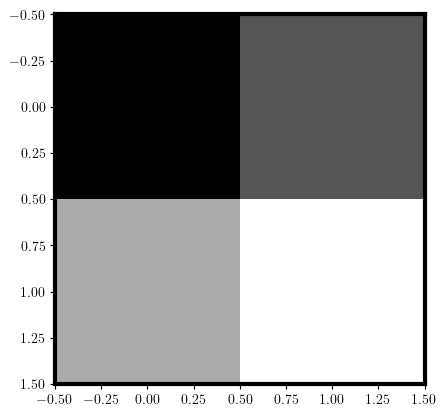

[0.        +0.j 0.26726124+0.j 0.53452248+0.j 0.80178373+0.j]


In [20]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
normalized = normalized.ravel() + 0j*np.zeros(4)
print(normalized)
